## Fine Tuning Transformer (DistilBert, but generic to other models) for MultiClass Text Classification (Sentimental Analysis over IMDb)

### Poc Introduction

Text classification is a common NLP task that assigns a label or class to text. Some of the largest companies run text classification in production for a wide range of practical applications. One of the most popular forms of text classification is sentiment analysis, which assigns a label like 🙂 positive, 🙁 negative, or 😐 neutral to a sequence of text.

This Poc will show you how to:

 - Finetune DistilBERT on the IMDb dataset to determine whether a movie review is positive or negative.
 - Use your finetuned model for inference (supports several model architectures...)

#### Flow of the notebook

The notebook will be divided into separate sections to provide a organized walk through for the process used. This process can be modified for individual use cases. The sections are:

1. [Importing Python Libraries and preparing the environment](#section01)
2. [Importing and Pre-Processing the domain data](#section02)
3. [Preparing the Dataset](#section03)
4. [Creating the Neural Network for Fine Tuning](#section04)
5. [Fine Tuning and validating the Model](#section05)
6. [Saving the model and artifacts for Inference in Future (tbd)](#section07)

#### Technical Details

This script leverages on multiple tools designed by other teams. Details of the tools used below. Please ensure that these elements are present in your setup to successfully implement this script.

 - Data:
	 - We are using IMDb data from datasets library Repository
	 - Where each row has the following data-point:
		 - label (0 negative, 1 positive)
		 - text

 - Language Model Used:
	 - DistilBERT this is a smaller transformer model as compared to BERT or Roberta. It is created by process of distillation applied to Bert.
	 - [Blog-Post](https://medium.com/huggingface/distilbert-8cf3380435b5)
	 - [Research Paper](https://arxiv.org/abs/1910.01108)
     - [Documentation for python](https://huggingface.co/transformers/model_doc/distilbert.html)
 - Supports several model architectures...


 - Hardware Requirements:
	 - Python 3.6 and above
	 - Pytorch, Transformers and All the stock Python ML Libraries
	 - GPU enabled setup


 - Script Objective:
	 - The objective of this script is to fine tune DistilBERT (but generic to severall models) on the IMDb dataset to determine whether a movie review is positive or negative (label 0 "negative", 1 "positive").


<a id='section01'></a>
### Importing Python Libraries and preparing the environment

At this step we will be importing the libraries and modules needed to run our script. Libraries are:
* Numpy
* Pandas
* Pytorch
* Dataset
* Transformers
* AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments,  Trainer
* Evaluate

Followed by that we will prepare the device for CUDA execution. This configuration is needed if you want to leverage on onboard GPU.

In [1]:
# Installing libraries (Transformers, datasets, evaluate, torch) needed
!pip install transformers
!pip install datasets
!pip install evaluate
!pip install transformers[torch] #due to torch accelerator


# Importing the libraries needed
import numpy as np
import pandas as pd
import torch
import transformers
from datasets import load_dataset, Dataset #from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForPreTraining, TrainingArguments,  Trainer, DataCollatorWithPadding #DistilBertModel, DistilBertTokenizer
import evaluate
import huggingface_hub


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 80.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 5.4 MB/s eta 0:00:00


In [2]:
# Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print ("Using device ", device)

Using device  cuda


<a id='section02'></a>
### Importing and Preparing the domain data

We will be working with the data and preparing for fine tuning purposes.
*From DataSets IMDb*.


The  Dataset will be something like this:

|label|text||
|--|--|--|
|  0 | text_1 |
|  1 | text_2 |
|  1 | text_3 |
|  0 | text_4 |

There are two fields in this dataset:

 - text: the movie review text.
 - label: a value that is either 0 for a negative review or 1 for a positive review.

If you like, you can create a smaller subset of the full dataset to fine-tune on to reduce the time it takes.



In [3]:
#Hugging face login
from huggingface_hub import notebook_login

notebook_login()

# Import IMDb dataset
imdb = load_dataset("imdb")

# option to reduce dataset size
# imdb = imdb.select (range(1000))



Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

<a id='section03'></a>
### Pre-Processing the Dataset

We will start with defining few key variables that will be used later during the training/fine tuning stage.

#### Dataset Tokenization
- We are using the DistilBERT tokenizer to tokenize the data
- To process your dataset in one step, use Datasets map method to apply a preprocessing function over the entire dataset
- Format pytorch ("torch")
- Create a batch of examples using DataCollatorWithPadding
- To read further into the tokenizer, [refer to this document](https://huggingface.co/transformers/model_doc/distilbert.html#distilberttokenizer)



In [5]:
# Defining some key variables that will be used later on in the training
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
EPOCHS = 3
LEARNING_RATE = 2e-05
MAXIMUM_SEQ_LENGHT = 256
WEIGHT_DECAY = 0.01
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

# Dataset Tokenization
modelnameused=  "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(modelnameused)

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_imdb = imdb.map(preprocess_function, batched=True)

#create a batch of examples using DataCollatorWithPadding. It’s more efficient to dynamically pad the sentences to the longest length in a batch during collation, instead of padding the whole dataset to the maximum length.
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

#tokenized_contratsAPFit = tokenized_contratsAPFit.with_format ("torch")

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

<a id='section04'></a>
### Creating the Neural Network for Fine Tuning

#### Neural Network
 - We will be creating a neural network with the `distilbert-base-cased`.
 - Defining training_args and compute metrics
 - You’ll push this model to the Hub by setting push_to_hub=True (you need to be signed in to Hugging Face to upload your model). At the end of each epoch, the Trainer will evaluate the accuracy and save the training checkpoint.

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def draw_confusion_matrix (predictions , labels):
  print ("Confusion Matrix: Focus on  classification Challenges")
  cm = confusion_matrix(labels, predictions)
  ConfusionMatrixDisplay(cm).plot()

metric = evaluate.load("accuracy")
#accuracy = evaluate.load("accuracy")

#Call compute on metric to calculate the accuracy of your predictions. Before passing your predictions to compute, you need to convert the predictions to logits (remember all 🤗 Transformers models return logits):
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    print ("predictions ", predictions)
    print ("labels      ", labels)
    draw_confusion_matrix (predictions , labels)
    return metric.compute(predictions=predictions, references=labels)

# Train with AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(
    modelnameused, num_labels=2, id2label=id2label, label2id=label2id
)


training_args = TrainingArguments (
    output_dir="test_trainer",
    evaluation_strategy="epoch",
    per_device_train_batch_size=TRAIN_BATCH_SIZE, #16,
    per_device_eval_batch_size=VALID_BATCH_SIZE, #16,
    num_train_epochs=EPOCHS, #3,
    learning_rate=LEARNING_RATE, #2e-5, #1e-5
    # maximum sequence length = MAXIMUM_SEQ_LENGHT
    weight_decay=WEIGHT_DECAY, #0.01,
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
)



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<a id='section05'></a>
### Fine Tuning and validating the Model

After all the effort of loading and preparing the data and datasets, creating the model and defining its variabels. This is probably the easier steps in the process.

Here we create a Trainer object with your model, training arguments, training and test datasets, and evaluation function.

During the validation stage we pass the unseen data(Testing Dataset) to the model. This step determines how good the model performs on the unseen data.

See Confusion Matrix of last prediction iteraton

As you can see the model is predicting the correct sentiment ~ 93% accuracy.


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.228900,0.270955,0.899040
2,0.160700,0.229983,0.930760


predictions  [0 0 0 ... 1 1 1]
labels       [0 0 0 ... 1 1 1]
Confusion Matrix: Focus on  classification Challenges
predictions  [0 0 0 ... 1 1 1]
labels       [0 0 0 ... 1 1 1]
Confusion Matrix: Focus on  classification Challenges


Epoch,Training Loss,Validation Loss,Accuracy
1,0.228900,0.270955,0.899040
2,0.160700,0.229983,0.930760
3,0.090900,0.272030,0.933200


predictions  [0 0 0 ... 1 1 1]
labels       [0 0 0 ... 1 1 1]
Confusion Matrix: Focus on  classification Challenges


TrainOutput(global_step=4689, training_loss=0.1680888712698525, metrics={'train_runtime': 6124.7803, 'train_samples_per_second': 12.245, 'train_steps_per_second': 0.766, 'total_flos': 9836511573418560.0, 'train_loss': 0.1680888712698525, 'epoch': 3.0})

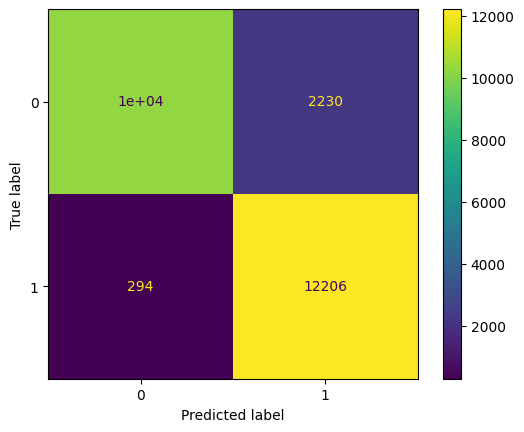

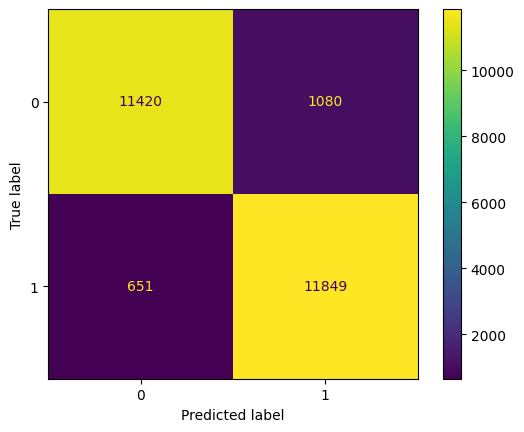

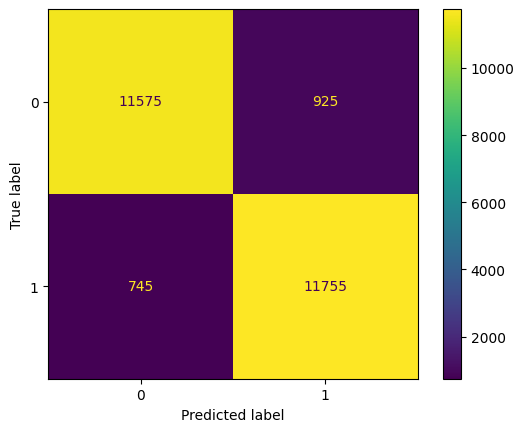

In [9]:
#Create a Trainer object with your distilbert model, training arguments, training and test datasets, and evaluation function:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_imdb["train"],
    eval_dataset=tokenized_imdb["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

#Then fine-tune your model by calling train():
trainer.train()

#Once training is completed, share your model to the Hub with the push_to_hub() method so everyone can use your model:
#trainer.push_to_hub()